In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-electronics-reviews-dataset/walmart_electronics_products_reviews_dataset_sample.csv


In [2]:
import pandas as pd

# Load the dataset
file_path = '/kaggle/input/walmart-electronics-reviews-dataset/walmart_electronics_products_reviews_dataset_sample.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset and some summary statistics
data.head(), data.describe()


(          id                                                url  \
 0  547476480  https://www.walmart.com/ip/TCL-28D2700-Stand-L...   
 1  547476480  https://www.walmart.com/ip/TCL-28D2700-Stand-L...   
 2  547476480  https://www.walmart.com/ip/TCL-28D2700-Stand-L...   
 3  151102224  https://www.walmart.com/ip/Restored-Apple-iPad...   
 4  151102224  https://www.walmart.com/ip/Restored-Apple-iPad...   
 
                                                 name        sku  price  \
 0  TCL 28D2700 Stand Legs W/Screws - USED(68-32D2...  547476480  19.95   
 1  TCL 28D2700 Stand Legs W/Screws - USED(68-32D2...  547476480  19.95   
 2  TCL 28D2700 Stand Legs W/Screws - USED(68-32D2...  547476480  19.95   
 3  Restored Apple iPad 2 16GB 9.7" Touchscreen Wi...  151102224  52.99   
 4  Restored Apple iPad 2 16GB 9.7" Touchscreen Wi...  151102224  52.99   
 
   currency primary_category reviewer_name  \
 0      USD      Electronics          Eric   
 1      USD      Electronics        Selina   


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                199 non-null    int64  
 1   url               199 non-null    object 
 2   name              199 non-null    object 
 3   sku               199 non-null    int64  
 4   price             199 non-null    float64
 5   currency          199 non-null    object 
 6   primary_category  199 non-null    object 
 7   reviewer_name     199 non-null    object 
 8   review_title      151 non-null    object 
 9   description       172 non-null    object 
 10  rating            199 non-null    int64  
 11  published_at      199 non-null    object 
 12  scraped_at        199 non-null    object 
dtypes: float64(1), int64(3), object(9)
memory usage: 20.3+ KB


In [4]:
# Data Cleaning: Checking for missing values and duplicates
missing_values = data.isnull().sum()
duplicate_rows = data.duplicated().sum()

missing_values, duplicate_rows


(id                   0
 url                  0
 name                 0
 sku                  0
 price                0
 currency             0
 primary_category     0
 reviewer_name        0
 review_title        48
 description         27
 rating               0
 published_at         0
 scraped_at           0
 dtype: int64,
 0)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


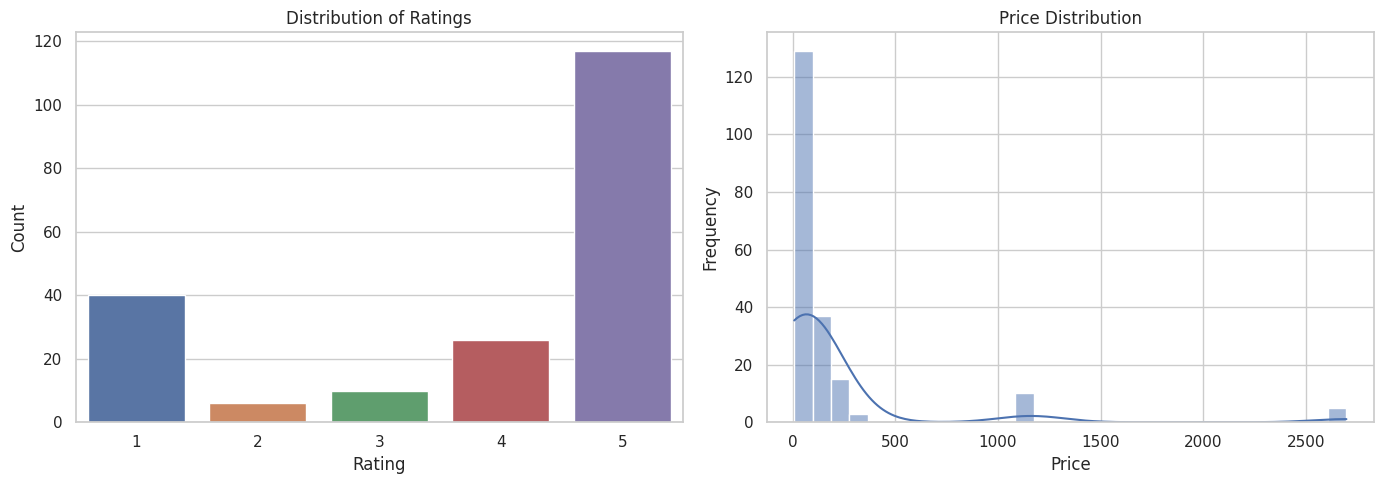

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Creating visualizations
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plotting the distribution of ratings
sns.countplot(x='rating', data=data, ax=ax[0])
ax[0].set_title('Distribution of Ratings')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Count')

# Plotting the distribution of prices
sns.histplot(data['price'], bins=30, ax=ax[1], kde=True)
ax[1].set_title('Price Distribution')
ax[1].set_xlabel('Price')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [6]:
from textblob import TextBlob

# Function to calculate sentiment polarity
def calculate_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

# Calculate sentiment polarity for review_title and description
data['review_title_sentiment'] = data['review_title'].apply(calculate_sentiment)
data['description_sentiment'] = data['description'].apply(calculate_sentiment)

# Compute the correlation of 'rating' with sentiment scores and other numerical features
sentiment_correlations = data[['rating', 'review_title_sentiment', 'description_sentiment']].corr()

sentiment_correlations


,rating,review_title_sentiment,description_sentiment
rating,1.000000,0.495853,0.519799
review_title_sentiment,0.495853,1.000000,0.467958
description_sentiment,0.519799,0.467958,1.000000


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from scipy.sparse import hstack

# Prepare the text data: combining 'review_title' and 'description' with filling NaNs
data['combined_text'] = data['review_title'].fillna('') + " " + data['description'].fillna('')

# Initializing the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Extract TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(data['combined_text'])

# Preparing the numeric feature 'price' (with scaling)
scaler = StandardScaler()
price_scaled = scaler.fit_transform(data[['price']])

# Combine TF-IDF features and price into one feature set
X = hstack([tfidf_features, price_scaled])
y = data['rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((159, 1796), (40, 1796))

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# Scoring dictionary
scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'RMSE': make_scorer(rmse, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

# Models to evaluate
models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression()
}

In [9]:
from sklearn.model_selection import cross_validate

# Adjusted process each model with cross_validate
results = {}

for name, model in models.items():
    # Define the pipeline
    pipeline = make_pipeline(
        TfidfVectorizer(stop_words='english', max_features=5000),
        StandardScaler(with_mean=False),  # TF-IDF output is sparse, this prevents conversion to dense array
        model
    )
    
    # Combine text data
    combined_text = data['review_title'].fillna('') + " " + data['description'].fillna('')
    
    # Perform cross-validation with multiple scoring metrics
    scores = cross_validate(pipeline, combined_text, y, cv=5, scoring=scoring)
    
    # Store results
    results[name] = scores

# To present the results, let's format them for better readability
formatted_results = {model: {metric: scores['test_' + metric].mean() for metric in scoring} for model, scores in results.items()}
formatted_results


{'RandomForestRegressor': {'MSE': -1.96986193318627,
  'RMSE': -1.3832499825822617,
  'R2': 0.1745082098909055},
 'GradientBoostingRegressor': {'MSE': -2.0764153552000355,
  'RMSE': -1.4189775755897984,
  'R2': 0.13344947328937345},
 'LinearRegression': {'MSE': -1.8118101376069269,
  'RMSE': -1.3171508649626211,
  'R2': 0.2549488872406735}}

In [11]:
from sklearn.model_selection import GridSearchCV

# Redefine a smaller parameter grid for RandomForest

param_grid_rf_reduced = {
    'n_estimators': [50, 100],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5]
}

# Initialize a new RandomForest model
model_rf_reduced = RandomForestRegressor(random_state=42)

# Pre-compute TF-IDF features outside of GridSearch to save time
tfidf_vectorizer_reduced = TfidfVectorizer(stop_words='english', max_features=2000)
X_tfidf_reduced = tfidf_vectorizer_reduced.fit_transform(combined_text)

# Set up GridSearchCV with the reduced parameter grid
grid_search_rf_reduced = GridSearchCV(model_rf_reduced, param_grid_rf_reduced, cv=3, scoring='r2', verbose=1)

# Perform grid search on the reduced feature set
grid_search_rf_reduced.fit(X_tfidf_reduced, y)

# Best parameters and best score from the reduced grid search
best_params_reduced_rf = grid_search_rf_reduced.best_params_
best_score_reduced_rf = grid_search_rf_reduced.best_score_

best_params_reduced_rf, best_score_reduced_rf


Fitting 3 folds for each of 8 candidates, totalling 24 fits


({'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100},
 0.13325895357688144)

In [12]:
# Train the RandomForest model with the best parameters on the full dataset
model_final_rf = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)

# Using the previously defined TF-IDF vectorizer
X_final_tfidf = tfidf_vectorizer_reduced.transform(combined_text)

# Fit the model on the entire dataset
model_final_rf.fit(X_final_tfidf, y)

# Predict ratings using the final model
predicted_ratings = model_final_rf.predict(X_final_tfidf)

# Add predicted ratings to the original dataframe for recommendation purposes
data['predicted_rating'] = predicted_ratings

# Display the head of the dataframe with actual and predicted ratings
data[['name', 'rating', 'predicted_rating']].head()


,name,rating,predicted_rating
0,TCL 28D2700 Stand Legs W/Screws - USED(68-32D2...,3,2.768383
1,TCL 28D2700 Stand Legs W/Screws - USED(68-32D2...,1,1.937139
2,TCL 28D2700 Stand Legs W/Screws - USED(68-32D2...,5,4.524330
3,"Restored Apple iPad 2 16GB 9.7"" Touchscreen Wi...",5,3.905200
4,"Restored Apple iPad 2 16GB 9.7"" Touchscreen Wi...",5,4.460000


In [13]:
# Filter and recommend products with predicted ratings of 4.5 or higher
recommended_products = data[data['predicted_rating'] >= 4.5].sort_values(by='predicted_rating', ascending=False)

# Display the recommended products
recommended_products[['name', 'rating', 'predicted_rating']].head()


,name,rating,predicted_rating
31,Roku Smart Home 5-Piece Home Monitoring System...,5,5.00
194,"LG 77"" Class 4K UHD 2160P OLED Smart TV with H...",5,5.00
67,Panasonic Expandable Cordless Phone with Enhan...,5,4.99
106,"Mount-lt! Dual Monitor Desk Mount | Fits 17""-3...",5,4.99
130,Fosmon Lightweight Portable Mini Wireless Blue...,5,4.99


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


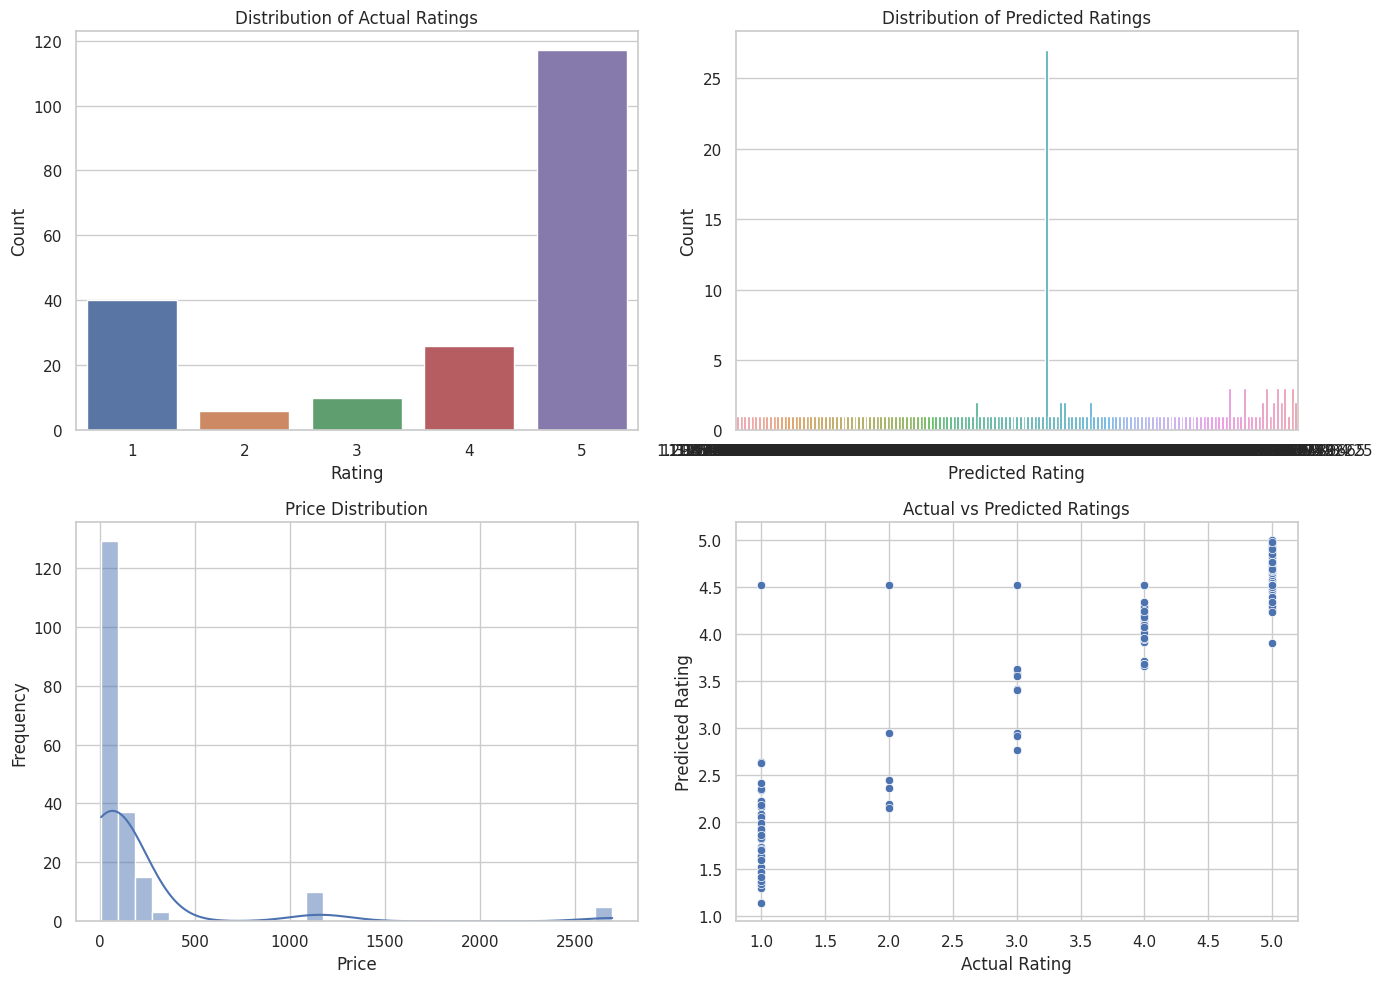

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Creating visualizations
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # Adjusted to include more subplots

# Plotting the distribution of actual ratings
sns.countplot(x='rating', data=data, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Actual Ratings')
axs[0, 0].set_xlabel('Rating')
axs[0, 0].set_ylabel('Count')

# Plotting the distribution of predicted ratings
sns.countplot(x='predicted_rating', data=data, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Predicted Ratings')
axs[0, 1].set_xlabel('Predicted Rating')
axs[0, 1].set_ylabel('Count')

# Plotting the distribution of prices
sns.histplot(data['price'], bins=30, ax=axs[1, 0], kde=True)
axs[1, 0].set_title('Price Distribution')
axs[1, 0].set_xlabel('Price')
axs[1, 0].set_ylabel('Frequency')

# Scatter plot of actual vs predicted ratings
sns.scatterplot(x='rating', y='predicted_rating', data=data, ax=axs[1, 1])
axs[1, 1].set_title('Actual vs Predicted Ratings')
axs[1, 1].set_xlabel('Actual Rating')
axs[1, 1].set_ylabel('Predicted Rating')

plt.tight_layout()
plt.show()
